<a href="https://colab.research.google.com/github/seonmia/MRC_KoBigBird_KoELECTRA/blob/main/Koelectra_with_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Mount & Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# train_file = "train.json"
# test_file = "test.json"
# result_path = "/content/drive/MyDrive/Colab Notebooks/KDT Project 2"
# blank_file = "blank.csv"

train_file = "data/train.json"
add_train_file = 'data/017.뉴스 기사 기계독해 데이터/01.데이터/1.Training/라벨링데이터/TL_span_extraction.json'
add_train_rev_file = "data/data_extraction_answer_len20.json"
test_file = "data/test.json"
result_path = "sub/"
blank_file = "data/blank.csv"


In [ ]:
%cd /content/drive/MyDrive/GoormProject/GoormProject2/

/content/drive/MyDrive/GoormProject/GoormProject2


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 11.8 MB/s 
     |████████████████████████████████| 596 kB 81.6 MB/s 
     |████████████████████████████████| 6.6 MB 69.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 66.2 MB/s 
     |████████████████████████████████| 156 kB 69.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filena

In [ ]:
import os
import random
import math
import csv
import json
from tqdm.notebook import tqdm
from easydict import EasyDict as edict
from statistics import mean
from typing import List, Tuple, Dict, Any

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import wandb

import torch
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F


from transformers import (
    BertTokenizer,
    BertForQuestionAnswering,
    AutoConfig,
    AdamW,
    AlbertTokenizer,
    AlbertForSequenceClassification,
    ElectraModel,
    ElectraTokenizer,
    ElectraForQuestionAnswering, 
    AutoModelForQuestionAnswering, 
    AutoTokenizer
)

# Config

In [ ]:
args = edict({'w_project': 'KoElectra',
              'w_entity': 'reodreamer', # WandB ID
              'learning_rate': 5e-5,
              'batch_size': {'train': 128,
                             'eval': 4,
                             'test': 128},
              'accumulate': 32,
              'epochs': 10,
              'seed': 42,
              'model_name': 'monologg/koelectra-base-v3-discriminator',
              'max_length': 512,
              'EarlyStopping' : True,
              'patience' : 5,
              })
args['NAME'] = ''f'koelectra_ep{args.epochs}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
print(args.NAME)

koelectra_ep10_lr5e-05_92


# Wandb

In [ ]:
do_wandb = True

In [ ]:
if do_wandb: wandb.login()

In [ ]:
if do_wandb: wandb.init(project = args.w_project, entity = args.w_entity)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
if do_wandb:
  wandb.run.name = args.NAME
  wandb.config.learning_rate = args.learning_rate
  wandb.config.epochs = args.epochs
  wandb.config.batch_size = args.batch_size

# Setting Model

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(args.seed)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name)


In [ ]:
# model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)
# model.to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForQuestionAnswering: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['qa_outputs.bias', 

In [ ]:
model.cuda();

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

# Preprocessing

## KoMRC

In [ ]:
from typing import List, Tuple, Dict, Any
import json
import random
import copy

class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices

    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)

##################################################################
    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, train_raio: float=.8,test_ratio: float=.5, seed=42):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[:int(len(indices) * train_raio)]
        split_indices = indices[int(len(indices) * train_raio):]
        eval_indices = split_indices[:int(len(split_indices) * test_ratio)]
        test_indices = split_indices[int(len(split_indices) * test_ratio):]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices), cls(dataset._data, test_indices)
################################################################################

    @classmethod
    def extraction(cls, dataset, data_number: int, save=False):
        '''
        첫 번째 인자 : KoMRC의 인스턴스
        두 번째 인자 : 추출할 data 개수 (단, data단위로 추출, indices단위가 아님)
        반환값 : KoMRC의 인스턴스
        '''
        if data_number > len(dataset):
            raise Exception("입력한 인자가 데이터셋 크기보다 큽니다.")
        else:
            data = copy.deepcopy(dataset._data)
            data['data'] = random.sample(data['data'], data_number)
            indices = []
            for d_id, document in enumerate(data['data']):
                for p_id, paragraph in enumerate(document['paragraphs']):
                    for q_id, _ in enumerate(paragraph['qas']):
                        indices.append((d_id, p_id, q_id))
            
            # 잘라낸 데이터를 저장
            if save:
                with open("cut_result.json", "w") as write_file:
                    json.dump(data, write_file, indent=4)
        
        return cls(data, indices)

    def __add__(self, other) :
        data = copy.deepcopy(self._data)
        data['data'] = self._data['data'] + other._data['data']
        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        return KoMRC(data, indices)
    

    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        context = paragraph['context']
        qa = paragraph['qas'][q_id]

        guid = qa['guid']
        question = qa['question']
        answers = qa['answers']


        return {
            'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)
    

In [ ]:
dataset1 = KoMRC.load(train_file) # train json 불러오고
dataset2 = KoMRC.load(add_train_rev_file) # 사전에 형식을 train.json 파일과 똑같이 만들어 놓은 TL_span_extraction2.json 파일을 불러오고
dataset2 = KoMRC.extraction(dataset2, int(len(dataset1)*.3))
dataset = dataset1 + dataset2

print(len(dataset1))
print(len(dataset2))
print(len(dataset))

12037
4444
16481


In [ ]:
from pprint import pprint
dataset = KoMRC.load(train_file)
pprint(dataset[0])

{'answers': [{'answer_start': 478, 'text': '한 달가량'},
             {'answer_start': 478, 'text': '한 달'}],
 'context': '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 '
            '전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 '
            '호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 '
            '하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 '
            '내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 '
            '줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 '
            '장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 '
            '시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 '
            '전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, '
            '강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 '
            '내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 '
            '것으로 예상돼 거리 응원에는 지

## TokenizedKoMRC

In [ ]:
from typing import Generator
class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tokenizer  = tokenizer

    
    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []
        sentence_tokens = []

        for word in sentence.split(): 
            if '[UNK]' in tokenizer.tokenize(word):
                sentence_tokens.append(word)
            else:
                sentence_tokens += tokenizer.tokenize(word)
        
        for morph in sentence_tokens:
            if len(morph) > 2:
                if morph[:2] == '##':
                    morph = morph[2:]

            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph)))) # morps의 시작 위치, 형태소의 길이 만큼을 더하면 그것이 캐릭터의 끝 위치.
            position += len(morph) # 포지션 업데이트 
        
        return tokens
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)
        # sample = {'guid': guid, 'context': context, 'question': question, 'answers': answers}

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)

        question = self._tokenizer.tokenize(sample['question'])

        if sample['answers'] is not None:
            answers = []
            # 추가된 코드
            local_shortest_answer_len = 200; local_shortest_answer_idx = 0
            for i, answer in enumerate(sample['answers']):
                if len(answer['text'])<local_shortest_answer_len:
                  local_shortest_answer_len = len(answer['text'])
                  local_shortest_answer_idx=i
            answer=sample['answers'][local_shortest_answer_idx]
            for start, (position_start, position_end) in enumerate(position):
                if position_start <= answer['answer_start'] < position_end:
                    break
            # else:
            #     print(context, answer)
            #     # print(answer['guid'])
            #     # print(answer['answer_start'])
            #     raise ValueError("No mathced start position")

            target = ''.join(answer['text'].split(' '))
            source = ''
            for end, morph in enumerate(context[start:], start):
                source += morph
                if target in source:
                    break
            # else:
            #     print(context, answer)
            #     # print(answers['guid'])
            #     # print(answers['answer_start'])
            #     raise ValueError("No Matched end position")

            answers.append({'start': start, 'end': end})
            answer_text = sample['answers'][0]['text']

        else:
            answers = None
            answer_text = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers,
            'answers_text': answer_text
        }

In [ ]:
dataset = TokenizedKoMRC.load(train_file)
train_dataset, dev_dataset, stest_dataset = TokenizedKoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Samples: 12037
Number of Train Samples: 9629
Number of Dev Samples: 1204
{'guid': 'e8a80bfc972b46589c28846b8c12b395', 'context_original': '디즈니 애니메이션 ‘겨울왕국’이 개봉 17일 만에 국내 역대 애니메이션 흥행 기록을 갈아치웠다. 2일 영화진흥위원회 영화관입장권통합전산망에 따르면 ‘겨울왕국’은 전날까지 544만명의 관객을 모아 ‘쿵푸팬더 2’(506만명)를 제치고 역대 애니메이션 흥행 신기록을 세웠다. 흥행 속도도 빨랐다. ‘겨울왕국’은 개봉 4일 만에 100만 관객을 돌파했고 9일 만에 200만, 11일 만에 300만 관객을 넘었다. 영화가 히트하면서 오리지널사운드트랙(OST) 앨범 ‘프로즌’(FROZEN)도 덩달아 인기다. 타이틀곡 ‘렛 잇 고’(Let it Go)는 벅스뮤직 일간 음원차트, 멜론의 실시간 차트에서 1위를 차지하는 등 각종 국내 음원차트에서 상위권에 올랐다. 이 영화를 수입·배급하는 소니 픽처스 릴리징 코리아는 ‘겨울왕국’이 조만간 뮤지컬 영화 최고 흥행 기록을 보유한 ‘레미제라블’(591만명)마저 넘어설 것으로 보고 있다. ‘겨울왕국’은 동화나라 왕국에 사는 마법을 가진 언니와 밝고 용감한 동생 간의 자매애를 다뤘다.', 'context_position': [(0, 3), (4, 9), (10, 11), (11, 13), (13, 14), (14, 15), (15, 16), (16, 17), (18, 20), (21, 23), (23, 24), (25, 26), (26, 27), (28, 30), (31, 33), (34, 39), (40, 42), (43, 45), (45, 46), (47, 49), (49, 50), (50, 51), (51, 52), (52, 53), (54, 55), (55, 56), (57, 59), (59, 61), (61, 64), (65, 68), (68, 69), (69, 70

## Indexer

In [ ]:
class Indexer:
    def __init__(self, vocabs: List[str], max_length: int=args.max_length):
        self.max_length = args.max_length
        self.vocabs = vocabs

    @property
    def vocab_size(self):
        return len(self.vocabs)
    @property
    def pad_id(self):
        return tokenizer.vocab['[PAD]']
    @property
    def unk_id(self):
        return tokenizer.vocab['[UNK]']
    @property
    def cls_id(self):
        return tokenizer.vocab['[CLS]']
    @property
    def sep_id(self):
        return tokenizer.vocab['[SEP]']


    def sample2ids(self, sample: Dict[str, Any],) -> Dict[str, Any]:
        context = [tokenizer.convert_tokens_to_ids(token) for token in sample['context']]
        question = [tokenizer.convert_tokens_to_ids(token) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(len(question) + 2 + answer['start'], self.max_length - 1)
            end = min(len(question) + 2 + answer['end'], self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end,
            'answers_text': sample['answers_text']
        }

In [ ]:
indexer = Indexer(list(tokenizer.vocab.keys()))
print(indexer.sample2ids(dev_dataset[0]))

{'guid': 'e8a80bfc972b46589c28846b8c12b395', 'context': '디즈니 애니메이션 ‘겨울왕국’이 개봉 17일 만에 국내 역대 애니메이션 흥행 기록을 갈아치웠다. 2일 영화진흥위원회 영화관입장권통합전산망에 따르면 ‘겨울왕국’은 전날까지 544만명의 관객을 모아 ‘쿵푸팬더 2’(506만명)를 제치고 역대 애니메이션 흥행 신기록을 세웠다. 흥행 속도도 빨랐다. ‘겨울왕국’은 개봉 4일 만에 100만 관객을 돌파했고 9일 만에 200만, 11일 만에 300만 관객을 넘었다. 영화가 히트하면서 오리지널사운드트랙(OST) 앨범 ‘프로즌’(FROZEN)도 덩달아 인기다. 타이틀곡 ‘렛 잇 고’(Let it Go)는 벅스뮤직 일간 음원차트, 멜론의 실시간 차트에서 1위를 차지하는 등 각종 국내 음원차트에서 상위권에 올랐다. 이 영화를 수입·배급하는 소니 픽처스 릴리징 코리아는 ‘겨울왕국’이 조만간 뮤지컬 영화 최고 흥행 기록을 보유한 ‘레미제라블’(591만명)마저 넘어설 것으로 보고 있다. ‘겨울왕국’은 동화나라 왕국에 사는 마법을 가진 언니와 밝고 용감한 동생 간의 자매애를 다뤘다.', 'question': "겨울왕국' 개봉 이전까지 누적 관객수가 가장 많았던 애니메이션은?", 'position': [(0, 3), (4, 9), (10, 11), (11, 13), (13, 14), (14, 15), (15, 16), (16, 17), (18, 20), (21, 23), (23, 24), (25, 26), (26, 27), (28, 30), (31, 33), (34, 39), (40, 42), (43, 45), (45, 46), (47, 49), (49, 50), (50, 51), (51, 52), (52, 53), (54, 55), (55, 56), (57, 59), (59, 61), (61, 64), (65, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 

## IndexerWrappedDataset

In [ ]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample

In [ ]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)
indexed_stest_dataset = IndexerWrappedDataset(stest_dataset, indexer)

sample = indexed_dev_dataset[0]
# print(sample['input_ids'], sample['attention_mask'], sample['token_type_ids'], sample['start'], sample['end'])
for i in sample:
  print(i,sample[i])

guid e8a80bfc972b46589c28846b8c12b395
context 디즈니 애니메이션 ‘겨울왕국’이 개봉 17일 만에 국내 역대 애니메이션 흥행 기록을 갈아치웠다. 2일 영화진흥위원회 영화관입장권통합전산망에 따르면 ‘겨울왕국’은 전날까지 544만명의 관객을 모아 ‘쿵푸팬더 2’(506만명)를 제치고 역대 애니메이션 흥행 신기록을 세웠다. 흥행 속도도 빨랐다. ‘겨울왕국’은 개봉 4일 만에 100만 관객을 돌파했고 9일 만에 200만, 11일 만에 300만 관객을 넘었다. 영화가 히트하면서 오리지널사운드트랙(OST) 앨범 ‘프로즌’(FROZEN)도 덩달아 인기다. 타이틀곡 ‘렛 잇 고’(Let it Go)는 벅스뮤직 일간 음원차트, 멜론의 실시간 차트에서 1위를 차지하는 등 각종 국내 음원차트에서 상위권에 올랐다. 이 영화를 수입·배급하는 소니 픽처스 릴리징 코리아는 ‘겨울왕국’이 조만간 뮤지컬 영화 최고 흥행 기록을 보유한 ‘레미제라블’(591만명)마저 넘어설 것으로 보고 있다. ‘겨울왕국’은 동화나라 왕국에 사는 마법을 가진 언니와 밝고 용감한 동생 간의 자매애를 다뤘다.
question 겨울왕국' 개봉 이전까지 누적 관객수가 가장 많았던 애니메이션은?
position [(0, 3), (4, 9), (10, 11), (11, 13), (13, 14), (14, 15), (15, 16), (16, 17), (18, 20), (21, 23), (23, 24), (25, 26), (26, 27), (28, 30), (31, 33), (34, 39), (40, 42), (43, 45), (45, 46), (47, 49), (49, 50), (50, 51), (51, 52), (52, 53), (54, 55), (55, 56), (57, 59), (59, 61), (61, 64), (65, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77

In [ ]:
with open("data/indexed_train_dataset_koel.json", "w", encoding='utf-8') as write_file:
    json.dump(list(indexed_train_dataset), write_file, indent=4)

with open("data/indexed_dev_dataset_koel.json", "w", encoding='utf-8') as write_file:
    json.dump(list(indexed_dev_dataset), write_file, indent=4)

with open("data/indexed_stest_dataset_koel.json", "w", encoding='utf-8') as write_file:
    json.dump(list(indexed_stest_dataset), write_file, indent=4)

# with torch.no_grad(), open('data/indexed_train_dataset_koel.csv', 'w') as fd:
#     writer = csv.writer(fd)
#     writer.writerow(['guid', 'context', 'question', 'position','input_ids', 'token_type_ids','start', 'end', 'answers_text', 'attention_mask'])

# with torch.no_grad(), open('data/indexed_dev_dataset_koel.csv', 'w') as fd:
#     writer = csv.writer(fd)
#     writer.writerow(['guid', 'context', 'question', 'position','input_ids', 'token_type_ids','start', 'end', 'answers_text', 'attention_mask'])

## Collator

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer

    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = { 
            key: [sample[key] for sample in samples] # 키 단위로 묶기
            for key in samples[0]
        }

        for key in 'start', 'end': # start랑 end는 숫자로 들어가서 패딩 필요 없음
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence( # 패딩
                [torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                batch_first=True, padding_value=self._indexer.pad_id
            )
        return samples


In [ ]:
collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset,
                          batch_size = args.batch_size.train // args.accumulate,
                          shuffle = True,
                          collate_fn = collator,
                          num_workers = 2)

dev_loader = DataLoader(indexed_dev_dataset,
                        batch_size = args.batch_size.eval,
                        shuffle = False,
                        collate_fn = collator,
                        num_workers = 2)


In [ ]:
batch = next(iter(dev_loader))
print(batch['input_ids'].shape)
print(batch['input_ids'])
print(list(batch.keys()))
# [CLS]는 2

torch.Size([4, 512])
tensor([[    2,  3223,  4043,  ...,   145,  2404,     3],
        [    2,  6631,  7568,  ...,     0,     0,     0],
        [    2,  3757,  7524,  ...,     0,     0,     0],
        [    2, 24213,  8579,  ...,  8579,  3231,     3]])
['guid', 'context', 'question', 'position', 'input_ids', 'token_type_ids', 'start', 'end', 'answers_text', 'attention_mask']


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Edit Distance

In [ ]:
# 출처: https://lsh424.tistory.com/78
def edit_distance(s:str, t: str):
    m = len(s)+1
    n = len(t)+1
    D = [[0]*m for _ in range(n)]
    D[0][0] = 0
    
    for i in range(1,m):
        D[0][i] = D[0][i-1] + 1
    
    for j in range(1,n):
        D[j][0] = D[j-1][0] + 1
    
    for i in range(1,n):
        for j in range(1,m):
            cost = 0

            if s[j-1] != t[i-1]:
                cost = 1
            
            D[i][j] = min(D[i][j-1] + 1,D[i-1][j] + 1, D[i-1][j-1] + cost)
    
    return D[n-1][m-1]

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=args.patience, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            # self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            # self.save_checkpoint(val_loss, model)
            self.counter = 0


# Train

In [ ]:
train_losses = []
dev_losses = []

train_loss = []
dev_loss = []

loss_accumulate = 0.

early_stopping = EarlyStopping(patience=args.patience, verbose=True)

best_model = [-1, int(1e9)]

for epoch in range(args.epochs):
    print("Epoch", epoch, '===============================================================================================================')

    # Train    
    progress_bar_train = tqdm(train_loader, desc='Train')
    for i, batch in enumerate(progress_bar_train, 1):
        del batch['guid'], batch['context'], batch['question'], batch['position'], batch['answers_text']
        batch = {key: value.cuda() for key, value in batch.items()}
        
        start = batch.pop('start')
        end = batch.pop('end')
        
        output = model(**batch)

        start_logits = output.start_logits
        end_logits = output.end_logits
        
        loss = (F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)) / args.accumulate
        loss.backward()

        loss_accumulate += loss.item()

        del batch, start, end, start_logits, end_logits, loss
        
        if i % args.accumulate == 0:
            # clip_grad_norm_(model.parameters(), max_norm=1.)
            optimizer.step()
            optimizer.zero_grad(set_to_none=False)

            train_loss.append(loss_accumulate)
            progress_bar_train.set_description(f"Train - Loss: {loss_accumulate:.3f}")
            loss_accumulate = 0.
        else:
            continue

        if i % int(len(train_loader) / (args.accumulate * 25)) == 0:
            # Evaluation
            for batch in dev_loader:
                del batch['guid'], batch['context'], batch['question'], batch['position'], batch['answers_text']
                batch = {key: value.cuda() for key, value in batch.items()}

                start = batch.pop('start')
                end = batch.pop('end')
                
                model.eval()
                with torch.no_grad():
                    output = model(**batch)
                
                    start_logits = output.start_logits
                    end_logits = output.end_logits
                model.train()

                loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

                dev_loss.append(loss.item())

                del batch, start, end, start_logits, end_logits, loss

            train_losses.append(mean(train_loss))
            dev_losses.append(mean(dev_loss))
            train_loss = []
            dev_loss = []

            
            if dev_losses[-1] <= best_model[1]:
                best_model = (epoch, dev_losses[-1])
                model.save_pretrained(f'models/{args.NAME}_{epoch}')
                # print(f'model saved!!\nvalid_loss: {dev_losses[-1]}')
                
            if do_wandb: wandb.log({"train_loss": train_losses[-1], "valid_loss": dev_losses[-1]})
            
            early_stopping(dev_losses[-1], model)

            if early_stopping.early_stop :
                print("Early stopping")
                break 

    print(f"Train Loss: {train_losses[-1]:.3f}")
    print(f"Valid Loss: {dev_losses[-1]:.3f}")
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

Epoch 0 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
Train Loss: 4.250
Valid Loss: 4.014
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 1 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Train Loss: 3.087
Valid Loss: 3.072
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 2 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping
Train Loss: 1.985
Valid Loss: 3.315
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 3 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 6 out of 5
Early stopping
Train Loss: 2.046
Valid Loss: 3.150
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 4 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 7 out of 5
Early stopping
Train Loss: 1.885
Valid Loss: 3.155
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 5 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 8 out of 5
Early stopping
Train Loss: 2.240
Valid Loss: 3.188
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 6 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 9 out of 5
Early stopping
Train Loss: 2.061
Valid Loss: 3.182
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 7 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 10 out of 5
Early stopping
Train Loss: 1.858
Valid Loss: 3.160
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 8 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 11 out of 5
Early stopping
Train Loss: 1.932
Valid Loss: 3.150
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 9 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

EarlyStopping counter: 12 out of 5
Early stopping
Train Loss: 1.810
Valid Loss: 3.224
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


In [ ]:
len(dev_losses)

68

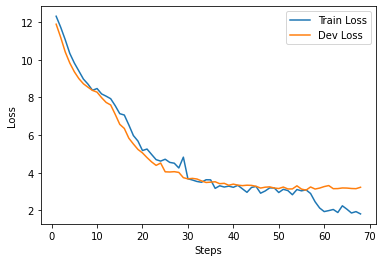

In [ ]:
import matplotlib.pyplot as plt

t = list(range(1, len(dev_losses)+1))
plt.plot(t, train_losses, label="Train Loss")
plt.plot(t, dev_losses, label="Dev Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test

In [ ]:
test_dataset = TokenizedKoMRC.load(test_file)
indexer_test = Indexer(list(tokenizer.vocab.keys()))
indexed_test_dataset = IndexerWrappedDataset(test_dataset, indexer_test)
print("Number of Test Samples", len(test_dataset))
# print(test_dataset[0])

Number of Test Samples 4008


In [ ]:
print(best_model[0])
print(f'models/{args.NAME}_{best_model[0]}')

1
models/koelectra_ep10_lr5e-05_316_1


In [ ]:
# 저장된 베스트 모델 가져오기 
model = AutoModelForQuestionAnswering.from_pretrained(f'models/{args.NAME}_{best_model[0]}')
model.cuda();


In [ ]:
for i in indexed_train_dataset[1]:
  print(i,':',indexed_train_dataset[1][i])

guid : 79f424fd9d404f18895fc9610153b2d7
context : 해양지각의 구조는 여러가지 방법을 통하여 직간접적으로 추론할 수 있다. 오피올라이트를 통한 암석 성분의 분석, 관측된 지진파 자료와 암석별 지진파 진행 속도의 비교, 해양저에서의 암석 채집 등의 방법이 사용되며, 물론 직접적인 굴착을 통해 지각 심부의 암석 표본을 얻을 수도 있다. 해양지각은 대륙지각에 비하여 훨씬 단순하며 대체로 다음의 세 층으로 구분될 수 있다.

* 1층은 미고결 또는 반 고결된 퇴적물층으로 얇으며, 중앙해령 근처에서는 아예 존재하지 않을 수도 있으나 해구쪽으로 갈수록 두꺼워진다. 대륙 연변부 근처에서는 대륙기원의 퇴적물들이 많아져서 퇴적층의 성분이 변화한다. 해양기원의 퇴적물은 주로 작은 해양생물의의 껍질로 주로 탄산염이나 규산염질인데 반하여 대륙기원의 퇴적물에는 화산재나 저탁류를 통해 운반된 퇴적물이 포함된다.
* 2층은 두 층으로 구분된다. 상부의 2A층은 유리질 또는 세립질 현무암의 침상용암으로 이루어져 있는 두께 약 0.5 km의 층이고, 아래의 2B층은 돌러라이트의 암맥으로 이루어진 두께 약 1.5 km의 층이다.
* 3층은 지표 아래에서 천천히 식어 이루어진 반려암을 비롯한 초염기성암으로 이루어져 있다. 해양지각 부피의 2/3 이상을 차지하며 두깨는 거의 5 km에 달한다.
question : 탄산염과 규산염질로 이루어진 퇴적물은 어디에서 온 것인가?
position : [(0, 2), (2, 3), (3, 4), (4, 5), (6, 8), (8, 9), (10, 12), (12, 14), (15, 17), (17, 18), (19, 21), (21, 22), (23, 26), (26, 27), (27, 29), (30, 32), (32, 33), (34, 35), (36, 37), (37, 38), (38, 39), (40, 42), (42, 44), (44, 46), (46, 47), (48, 50), (51, 53), (54, 56

In [ ]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]
    print(start_str,end_str)
    pred_ans = sample['context'][start_str:end_str]
    print('Predicted Answer:', pred_ans)
    print('Real Answer:',sample['answers_text'])
    print('Edit Distance:',edit_distance(pred_ans,sample['answers_text']))
    

------1------
Context: 한국은 캐나다와 자유무역협정(FTA)을 맺으면서 ‘경제영토’를 북미 전체로 확장하게 됐다. 캐나다는 G8 회원국이자 세계 11위 경제 대국이다. 한국과의 교역 규모는 지난해 99억2200만달러로 적은 편이지만 시장의 잠재 성장 가능성은 높다는 평가다. 특히 FTA 발효 2년 후 자동차 관세가 완전 철폐되면서 한국산 자동차의 가격 경쟁력이 높아질 전망이다. ○일본 앞서 시장 선점한·캐나다 FTA 체결로 가장 이득을 보는 품목은 자동차다. 캐나다는 한국의 5대 자동차시장이다. 지난해 캐나다에 수출한 자동차 수는 13만3000대. 캐나다는 현재 한국산 자동차에 부과하는 관세 6.1%를 발효 시점부터 2년 동안 단계적으로 없애기로 했다. 이렇게 되면 일본·유럽산 자동차보다 가격경쟁력에서 앞설 수 있게 된다. 북미자유무역협정(NAFTA) 회원국인 미국·멕시코산 자동차와 비슷한 조건에서 경쟁할 수 있다. 작년 캐나다 자동차시장 점유율은 미국 44.5%, 일본 33.6%, 한국 12.0%, 유럽 9.9% 등이다. 캐나다가 일본과 FTA 협상을 진행 중이고 유럽연합(EU)과는 추가 협상 문제로 발효가 늦어지고 있어 FTA 발효를 서두른다면 적어도 수년간은 시장 선점 효과를 누릴 수 있을 것으로 보인다. 김태년 한국자동차산업협회 이사는 “소형차의 경우 영업이익률이 3%밖에 안되기 때문에 관세 철폐 효과가 클 것으로 기대된다”고 말했다.주요 수출 품목인 자동차 부품도 3년 내 6%에 달하는 관세가 사라진다. 7%에 이르는 타이어 관세는 5년 뒤 완전 철폐된다. 관세율이 8%인 세탁기는 FTA 발효 즉시 없어지고, 6%인 냉장고 관세도 3년 내 철폐돼 가전제품 수출에도 파란불이 켜졌다. 평균 관세율 5.9%인 섬유도 대부분 3년 내 관세가 사라진다. 개성공단 원산지 인정 문제에 관해서는 향후 역외가공지역위원회 설립과 충족 기준을 논의하기로 했다. 이와 관련, 박근혜 대통령은 “개성공단 제품이 한국산으로 인정받아 관세 혜택을 받을 수 있도록

In [ ]:
for idx, sample in zip(range(1, 4), indexed_dev_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]
    print(start_str,end_str)
    pred_ans = sample['context'][start_str:end_str]
    print('Predicted Answer:', pred_ans)
    print('Real Answer:',sample['answers_text'])
    print('Edit Distance:',edit_distance(pred_ans,sample['answers_text']))

------1------
Context: 지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람이 분다.날것 그대로의 직설 화법으로 풀어 놓는 풍성한 인생 

In [ ]:
pred_answers = []
real_answers = []

In [ ]:
edit_dists = []
for sample in tqdm(indexed_dev_dataset):
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]
    pred_ans = sample['context'][start_str:end_str]
    if len(pred_ans)>20: pred_ans=''
    edit_dists.append(edit_distance(pred_ans,sample['answers_text']))
    pred_answers.append(pred_ans); real_answers.append(sample['answers_text'])

  0%|          | 0/1203 [00:00<?, ?it/s]

In [ ]:
max(len(i) for i in pred_answers)

20

In [ ]:
# 실제 답변 길이에 대해 예측 길이
pred_arr = [[0]*20 for _ in range(21)]
for i in range(len(pred_answers)):
  if len(real_answers[i])>20: continue
  pred_arr[len(real_answers[i])][len(pred_answers[i])]+=1
plt.matshow(pred_arr)
plt.xlabel('Length of Real Answer')
plt.ylabel('Length of Predicted Answer')
plt.colorbar()
plt.show()

IndexError: ignored

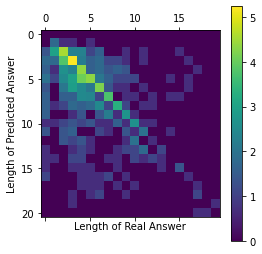

In [ ]:
import math
squared_pred_arr=[[0]*20 for _ in range(21)]
for i in range(21):
  for j in range(20):
    squared_pred_arr[i][j] = math.log(pred_arr[i][j]+1)
plt.matshow(squared_pred_arr)
plt.xlabel('Length of Real Answer')
plt.ylabel('Length of Predicted Answer')
plt.colorbar()
plt.show()

In [ ]:
pred_real_ratio = [len(pred_answers[i])/len(real_answers[i]) if len(real_answers[i]) else 0
                   for i in range(len(pred_answers))]
print(sum(pred_real_ratio)/len(pred_real_ratio))

0.9120369887518551


In [ ]:
from collections import Counter
edit_dists_counter = Counter(edit_dists)
dists_list=list(edit_dists_counter.items()); dists_list.sort()
dists_keys = [i[0] for i in dists_list]
dists_vals = [i[1] for i in dists_list]

print('Average:',sum(edit_dists)/len(edit_dists))

Average: 3.2593516209476308


In [ ]:
tmp=0; dists_sum = sum(dists_vals)
for i, j in dists_list:
  tmp+=j
  print(f'편집 거리 {i} - {j}개 ({j/dists_sum*100:.2f}%) - 누적 {tmp/dists_sum*100:.2f}%')

편집 거리 0 - 538개 (44.72%) - 누적 44.72%
편집 거리 1 - 136개 (11.31%) - 누적 56.03%
편집 거리 2 - 130개 (10.81%) - 누적 66.83%
편집 거리 3 - 103개 (8.56%) - 누적 75.39%
편집 거리 4 - 60개 (4.99%) - 누적 80.38%
편집 거리 5 - 45개 (3.74%) - 누적 84.12%
편집 거리 6 - 32개 (2.66%) - 누적 86.78%
편집 거리 7 - 30개 (2.49%) - 누적 89.28%
편집 거리 8 - 24개 (2.00%) - 누적 91.27%
편집 거리 9 - 23개 (1.91%) - 누적 93.18%
편집 거리 10 - 13개 (1.08%) - 누적 94.26%
편집 거리 11 - 15개 (1.25%) - 누적 95.51%
편집 거리 12 - 8개 (0.67%) - 누적 96.18%
편집 거리 13 - 8개 (0.67%) - 누적 96.84%
편집 거리 14 - 7개 (0.58%) - 누적 97.42%
편집 거리 15 - 2개 (0.17%) - 누적 97.59%
편집 거리 16 - 6개 (0.50%) - 누적 98.09%
편집 거리 17 - 3개 (0.25%) - 누적 98.34%
편집 거리 19 - 2개 (0.17%) - 누적 98.50%
편집 거리 20 - 1개 (0.08%) - 누적 98.59%
편집 거리 21 - 3개 (0.25%) - 누적 98.84%
편집 거리 23 - 2개 (0.17%) - 누적 99.00%
편집 거리 24 - 3개 (0.25%) - 누적 99.25%
편집 거리 25 - 1개 (0.08%) - 누적 99.33%
편집 거리 29 - 1개 (0.08%) - 누적 99.42%
편집 거리 32 - 2개 (0.17%) - 누적 99.58%
편집 거리 33 - 2개 (0.17%) - 누적 99.75%
편집 거리 34 - 1개 (0.08%) - 누적 99.83%
편집 거리 36 - 1개 (0.08%) - 누적 99.92%
편집 거리

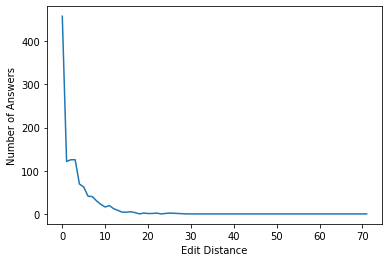

In [ ]:
plt.plot(dists_keys, dists_vals)
plt.xlabel('Edit Distance')
plt.ylabel('Number of Answers')
plt.show()

In [ ]:
start_visualize = []
end_visualize = []

with torch.no_grad(), open(f'{args.NAME}.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    c = 0
    # for sample in tqdm(test_dataset, "Testing"):
    for sample in tqdm(indexed_test_dataset, "Testing"):
        input_ids, token_type_ids = [torch.tensor(sample[key], dtype=torch.long, device="cuda") for key in ("input_ids", "token_type_ids")]
        # print(sample)
    
        model.eval()
        with torch.no_grad():
            output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

        start_logits = output.start_logits
        end_logits = output.end_logits
        start_logits.squeeze_(0), end_logits.squeeze_(0)

        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

        # 토큰 길이 8까지만
        for row in range(len(start_prob) - 8):
            probability[row] = torch.cat((probability[row][:8+row].cpu(), torch.Tensor([0] * (len(start_prob)-(8+row))).cpu()), 0)

        index = torch.argmax(probability).item()

        start = index // len(end_prob)
        end = index % len(end_prob)
        
        # 확률 너무 낮으면 자르기
        if start_prob[start] > 0.3 and end_prob[end] > 0.3:
            start_str = sample['position'][start][0]
            end_str = sample['position'][end][1]
        else:
            start_str = 0
            end_str = 0

        start_visualize.append((list(start_prob.cpu()), (start, end), (start_str, end_str)))
        end_visualize.append((list(end_prob.cpu()), (start, end), (start_str, end_str)))
        
        rows.append([sample["guid"], sample['context'][start_str:end_str]])

    writer.writerows(rows)

Testing:   0%|          | 0/4008 [00:00<?, ?it/s]